
# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [1]:
names = {'student_1': "Manana Lortkipanidze",
         'student_2': "Devavrat Tomar"}

sciper = {'student_1': 263851, 
          'student_2': 295271}

seed = sciper['student_1'] + sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os, sys
import copy
from random import randint

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

def getRawDataFromFile(datapath="data/personachat/", file="train_both_revised.txt"):
    f = open(datapath+file)
    conversations = []
    current_conversation = []
    for l, line in enumerate(f):
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue
        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

Using TensorFlow backend.


In [2]:
# helpers from mini-project 1
import matplotlib.pyplot as plt

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    #ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    
    for i, hist in enumerate(history):
        ax1.plot(hist['loss'], label = "training_run_"+str(i))
        ax1.plot(hist['val_loss'], label = "validation_run_"+str(i))
        ax2.plot(hist['acc'], label = "training_run_"+str(i))
        ax2.plot(hist['val_acc'], label = "validation_run_"+str(i))

    finalize_standardplot(fig, ax1, ax2)
    ax1.grid()
    ax2.grid()
    fig.set_figheight(5)
    fig.set_figwidth(15)
    return fig

## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [3]:
conversations = getRawDataFromFile()

In [4]:
random_int = np.random.randint(0, len(conversations), 2)
# Displaying conversation 
print("Two randomly selected conversations: \n{}\n{}".format(conversations[random_int[0]], conversations[random_int[1]]))

Two randomly selected conversations: 
['hey , do you want to take me to the movies ?', 'uh , it would depend on the movie i guess', 'you could pick , whatever you want', 'well , in general whats your favorite movie ?', 'hmmm . . maybe superhero movies . maybe no .', 'it depends the superhero , some of them are just overplayed', 'that is very rude of you to say . you cannot borrow my cape now', 'i wear my own kind of cape , i work as a paramedic', 'i do not understand what that even means honestly', 'i save lives like superheros , i work in an ambulance', 'but what brand cape do you wear ?', 'its gucci , why you asking ?', 'i was just curious . mine is probably better than yours .', 'the arrogance is strong in this one , yes', 'so , anyway , what movie are you taking me to see ?', 'well , how about dumb and dumber ?']
['i live in a house with cats , there are cats in my yard too', 'cats do not have souls so i do not see them at church when i sing in the choir', 'oh well , we all think d

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer** Zip's law suggests that rank of a word is inversely propotional to its frequency. Therefore, such relationship should result in a linear relationship on log-log scale with negative slope $frequency$ ~ $\frac{1}{rank^a}$. As we can see from out plot we have approximately line (with negative slope). Thus, we can say that Zip's law approximately holds. However, we can observe nonlinearity(oscillations) at the end which usually can disappear with cumulative frequency distribution.

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer** 7080 words appeared only once.



<b>Code Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt] </b>

In [5]:
def get_word_dictionary(conversations):
    """
    Computes the set of unique words (dictionary) in all sentences along with their number of occurences.
    
    :param conversations: List of all conversations
    """
    word_dict = {}
        
    print("Creating dictionary")
    # First we need to extract all sentences from conversations
    for conversation in conversations:
        for sentence in conversation:
            words = sentence.split(' ')
            for word in words:
                if word in word_dict:
                    word_dict[word] += 1
                else:
                    word_dict[word] = 1
                    
                    
    print("Number of unique words: %d"%len(word_dict))
    
    return word_dict

In [6]:
word_dictionary = get_word_dictionary(conversations)
sorted_word_dictionary = sorted(word_dictionary.items(), key=lambda kv: kv[1], reverse=True)

Creating dictionary
Number of unique words: 18673


<b>Figure: In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]</b>

In [7]:
def plot_bar_tuples(list_tuples, title, x_label, y_label, fig_size=(15,8)):
    """
    Create bar chart with vertical labels on x-axis
    
    :param list_tuples: labels with their corresponding count
    :param title:       title of the plot
    :param x_label:     label for the x-axis
    :param y_label:     label for the y-axis
    :param fig_size:    size of the figure, optional
    """
    plt.figure(figsize=fig_size)
    x , y = zip(*list_tuples)
    x_pos = np.arange(len(list_tuples))
    plt.bar(x_pos, y, align='center', alpha=0.5)
    plt.xticks(x_pos, x, rotation='vertical')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
   
    plt.show()   

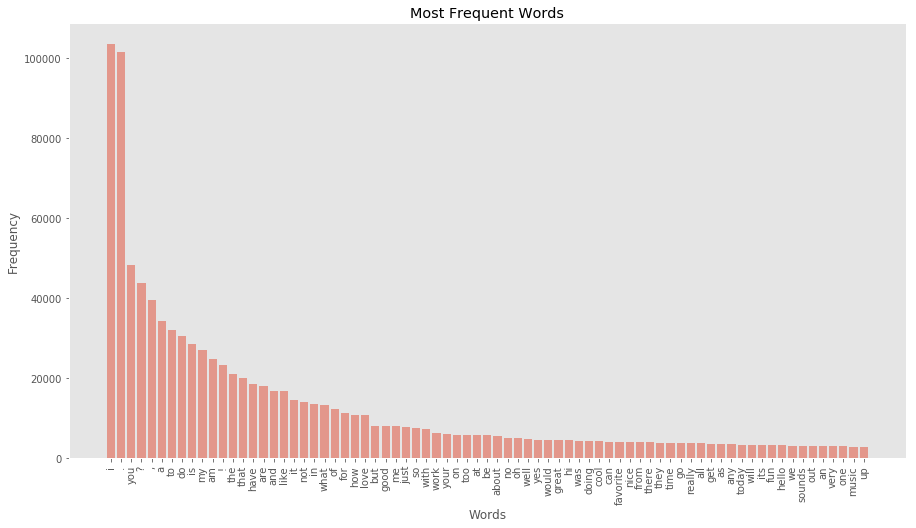

In [8]:
plot_bar_tuples(sorted_word_dictionary[0:75], "Most Frequent Words", "Words", "Frequency")

<b>Figure In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] </b>

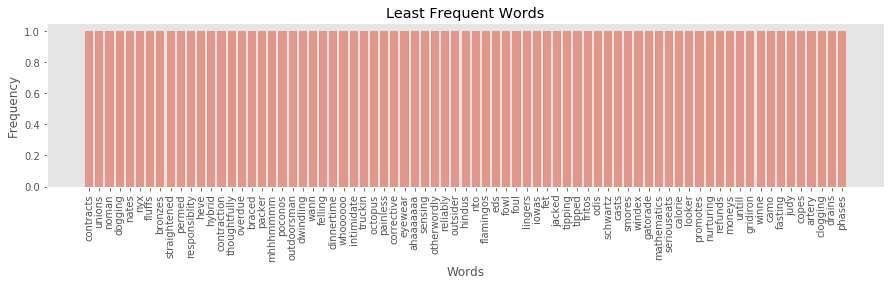

In [9]:
plot_bar_tuples(sorted_word_dictionary[-75:], "Least Frequent Words", "Words", "Frequency", (15,3))

<b>Figure In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]</b>

In [10]:
def plot_log_log(data, title, x_label, y_label):
    """
    Plot data on log-log axis
    
    :param data:      data to be plotted
    :param title:     title of the figure
    :param x_label:   label of the x-axis
    :param y_label:   label of the y-axis
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    fig.suptitle(title)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_ylim(1, max(data))
    ax.set_xlim(1, max(data))
    plt.gca().set_aspect('equal', adjustable='box')
    ax.plot(data)

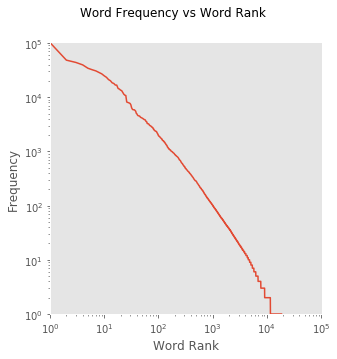

In [11]:
plot_log_log([word_count[1] for word_count in sorted_word_dictionary],
             "Word Frequency vs Word Rank", "Word Rank", "Frequency")

<b>Question How many words appear only once in the entire dataset? [1 pt]</b>

In [12]:
# number of words with count one
words_count_one = [word_count[0] for word_count in word_dictionary.items() if word_count[1] == 1]

In [13]:
count_one_nb   = len(words_count_one)
count_one_perc = len(words_count_one) * 100.0 / len(word_dictionary)
print("Number of words that occur only once: %d (%0.2f%% of the whole vocabulary)"%(count_one_nb, count_one_perc))

Number of words that occur only once: 7080 (37.92% of the whole vocabulary)


### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: Removed 13881 words from total of 18673 words.

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: 104488 sentences in filtered and 131424 sentences in the old dataset.

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**:  In case of the language modelling, removing a rare word from  a dataset will result in a model not aware of the word (would not be able to generate it). However, even if we included it, learning would see little to no benefit since rare words appear just a few times so there is not enough data for the model to generalize and learn from it.  Additionally, by removing rare words we significantly reduce the size of prediction classes (vocabulary size) without losing much of the information/generative power (thanks to the Zip's law) that is crucial for computational point of view. Therefore, removing them is usually a good idea/accepted approach. It has to be noted, that removing all sentences with rare words might significantly reduce our dataset so it is a trade-off between keeping reasonable amount of data and preventing attempt to learn very skewed/rare/unlikely to occur classes (words).

<b>Code To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]</b>

In [14]:
threshold=10
filtered_dict = {k:v for k,v in word_dictionary.items() if v >= threshold}
rare_words = {k for k,v in word_dictionary.items() if v < threshold}
print("Removed %d words from total of %d words"%(len(rare_words), len(word_dictionary)))

Removed 13881 words from total of 18673 words


In [15]:
def contains_rare_word(sentence, rare_words):
    """
    Checks if sentence contains any of the rare words
    :param sentence:   Sentence to be checked
    :param rare_words: List of the rare words
    
    :return:           Whether sentence contains any of the rare words
    """
    for word in sentence:
        if word in rare_words:
            return True
    return False

def filter_dataset(conversations, rare_words):
    """ 
    Returns filtered dataset containing sentences in which rare words do not accur
    
    :conversations: conversations dataset
    :rare_words:    list of rare words
    
    :return:        filtered dataset
    """
    
    filtered_dataset = []
    old_sentence_nb  = 0
    filt_sentence_nb = 0
    
    for conversation in conversations:
        filtered_conversation = []
        for sentence in conversation:
            split_sentence = sentence.split(" ")
            
            if (not contains_rare_word(split_sentence, rare_words)):
                filtered_conversation.append(split_sentence)
        
        if filtered_conversation: # If it is not empty
            filtered_dataset.append(filtered_conversation)
            
        old_sentence_nb  += len(conversation)
        filt_sentence_nb += len(filtered_conversation)
        
    print("Filtered %d out of %d sentences"%(old_sentence_nb-filt_sentence_nb, old_sentence_nb))
    print("%d sentences in filtered and %d sentences in an old dataset."%(filt_sentence_nb, old_sentence_nb))

    return filtered_dataset

In [16]:
filtered_conversations = filter_dataset(conversations, rare_words)

Filtered 26936 out of 131424 sentences
104488 sentences in filtered and 131424 sentences in an old dataset.


### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

<b>Code Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. HINT: use the Python List index() method. [2 pts]</b>

In [17]:
def create_dict_mapping(dictionary):
    """
    Creates an array from dictionary where index of an token is its mapping
    
    :param dictionary: dictionary to be mapped
    
    :return: mapping of the dictionary
    """
    dict_mapping = ['PADD']
    dict_mapping += list(dictionary)
    dict_mapping.append('START')
    dict_mapping.append('END')
    
    return dict_mapping
    
dict_mapping = create_dict_mapping(filtered_dict)

In [18]:
def map_conversations(conversations, dict_mapping):
    """
    Maps words/tokens of conversation to its corresponding integers
    
    :param conversations:   conversation to be mapped
    :param dict_mapping:    mapping of tokens defined by their index
    
    :return: mapped conversation
    """
    
    mapped_conversations = []
    
    for conversation in conversations:
        mapped_conversation = []
        for sentence in conversation:
            mapped_sentence = [dict_mapping.index('START')]
            for word in sentence:
                mapped_sentence.append(dict_mapping.index(word))
            mapped_sentence.append(dict_mapping.index('END'))
            mapped_conversation.append(mapped_sentence)
        mapped_conversations.append(mapped_conversation)
    return mapped_conversations

mapped_conversations = map_conversations(filtered_conversations, dict_mapping)

<b>Figure: Use the violinplot to show the density of tokenized sentences length. [1pt]</b>

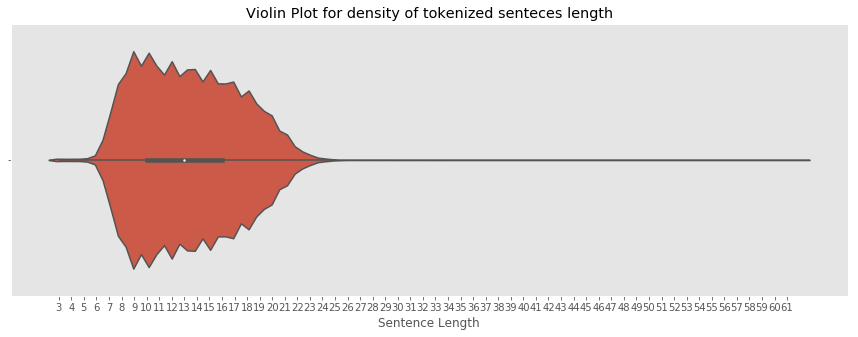

In [19]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 5))
#plt.figure(figsize=(15, 5))
plt.title("Violin Plot for density of tokenized senteces length")
sentence_length = [len(sentence) for conversation in mapped_conversations for sentence in conversation]
sns.violinplot(x=sentence_length)
start, end = (min(sentence_length), max(sentence_length))
ax.xaxis.set_ticks(np.arange(start, end, 1))
ax.set_xlabel("Sentence Length")
plt.show()

<b> Code: From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen). HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts] </b>

In [20]:
def standardize_conversations(conversations, max_tokens):
    """
    Standardizes conversations so that each sentence has max_tokens tokens either padding or truncating
    
    :param conversations: conversations to be standardized
    :param max_tokens:    number of tokens per sentence
    
    :return:              standardized conversations
    """
    stand_convs = []
    
    for conversation in conversations:
        stand_convs.append(pad_sequences(conversation, maxlen=max_tokens, padding='post', truncating='post'))    
    return stand_convs

In [21]:
#approx. 99th quartile and according to violin plot most of the sentences have lesser length
max_tokens = 25

In [22]:
stand_convs = standardize_conversations(mapped_conversations, max_tokens)

<b> Code Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt] </b>

In [23]:
def recover_sentence(sentence, mapped_dict):
    # remove padding
    unpadded_sentence = [index for index in sentence if index != dict_mapping.index('PADD')]
    # map integers back to words
    word_sentence = [mapped_dict[index] for index in unpadded_sentence]
    # remove start and end
    return word_sentence[1:-1]

In [24]:
# original sentences 
sentences = [sentence for conversation in filtered_conversations for sentence in conversation]
# standardizes sentences with tokenization, padding and length standardization
std_sentences = np.array([sentence for conversation in stand_convs for sentence in conversation])

In [25]:
# reconstruct two random sentences
for i in range(2):
    index = randint(0, len(sentences))
    print("Original Sentence: %s"%sentences[index])
    print("Standardized Sentence: %s"%std_sentences[index])
    print("Reconstructed Sentence: %s \n"%recover_sentence(std_sentences[index], dict_mapping))

Original Sentence: ['anything', 'without', 'meat', 'since', 'i', 'am', 'a', 'vegetarian']
Standardized Sentence: [4793   75 1245   60   61    8    9   55  456 4794    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
Reconstructed Sentence: ['anything', 'without', 'meat', 'since', 'i', 'am', 'a', 'vegetarian'] 

Original Sentence: ['well', ',', 'i', 'would', 'say', 'soup', '!', 'how', 'far', 'along', 'are', 'you', '?']
Standardized Sentence: [4793  186    2    8   66   67 2482   31    3  840  177    4    5    7
 4794    0    0    0    0    0    0    0    0    0    0]
Reconstructed Sentence: ['well', ',', 'i', 'would', 'say', 'soup', '!', 'how', 'far', 'along', 'are', 'you', '?'] 



### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [26]:
import pickle

def save_data():    
    #save
    with open("data.pkl", "wb") as file:
        pickle.dump([filtered_conversations, filtered_dict, dict_mapping, std_sentences], file)

def load_data():
    #load
    with open("data.pkl", "rb") as file:
         return pickle.load(file)
        
save_data()
# !!! for the second time run comment the save_date() line above !!!

[filtered_conversations, filtered_dict, dict_mapping, std_sentences] = load_data()

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer** We include a mask layer after the embedding layer (using argument mask_zero=True in Embedding keras layer) treating 'PADD' (integer 0) input as end of the sequence. This allows RNN to process sequences of arbitary length from 1 to max_token and **discard padded inputs**.

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer** This network is modelled to predict next word given the "history" (function of) previous  $n$ words in the sentence. Thus, we can treat the softmax output of the neural network as conditional probability distribution of $(n+1)^{th}$ word given the history of past $n$ words (i.e. transition probability of next word, given the history of the past words).

For each batch, the inputs are the **integer** word sequences which is passed to the embedding layer that transforms integers to meaningful vector representation before feeding them to recurrent neural network and targets are the same word sequences (**one hot representation of words instead of integer**) but with one step delayed. Thus, the neural network learns to predict next word in the sentence given previous words.

**Input tensor dimension**: [batch_size, max_time_step -1, 1]  
**Output tensor dimension**: [batch_size, max_time_step -1, vocabulary_size]  

Where max_time_step is the length of a given sentence and vocabulary size is the size of the unique word tokens used in dataset.

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: Both 'GRU' and 'LSTM' reach almost the same validation accuracy which is also the highest achieved among the three units (we use dropouts to combat overfitting). 'GRU' and 'LSTM' take the same number of epochs to achieve the best accuracy. However, GRU is slightly faster (takes less time for each epoch) compared to LSTM due to lesser number of parameters. RNN is the slowest one which might be because of the vanishing gradient problem. (We trained each model many times during testing/writing the code and the results were the same. However, because of computational/time limitations we did not do cross-validation.)

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: Yes, we observe overfitting for all cases (RNN, LSTM, GRU) without using any regularisation like dropouts. One of the explanations could be that some of the classes (words) occur just a few times (uneven class distribution of data points) in the training set, which makes it difficult for the network to generalize. We can observe this uneven class distribution from **zip's law** plot above. It could also be memorizing some of the sentences because of the above mentioned reason. Therefore, lack of data (especially minority classes) could be one of the possible explanation. However, using dropouts solves the problem and model learns without overfitting.

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: One option would be to have a higher threshold (**smaller vocablary size**) that would lead to sentences with words occuring quite often. In terms of classification, there would be many examples for each class. Therefore, network will easily learn to generalize and overfitting would be less likely to occur.

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: Reducing complexity of network (size of LSTM units)(having less parameters to learn) or introducing dropout layers would decrease overfitting .

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: Early stopping could be used to counter overfitting. We can also add L2 norm of model weights to the loss function to prevent learning larger weights. (Or one could let it overfit and then select the best one)

<b>code You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]</b>

In [35]:
nb_tokens = len(dict_mapping)
print("Size of dictionary: %d"%nb_tokens)

Size of dictionary: 4795


In [36]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

In [37]:
# input layers
I = {}
# embedding layers
E = {}
# hidden layers
H = {}
# readout
R = {}
# output 
Y = {}
models = {}
logs = {}

In [38]:
X = std_sentences
# convert output to shape [batch_size, max_step, feature_size]
T = std_sentences.reshape((std_sentences.shape[0], std_sentences.shape[1], 1))

In [58]:
def append_run_language_model(nb_tokens,
                              input_len,
                              embedding_size,
                              hidden_size,
                              n_hidden_layers,
                              I, E, H, R, Y,
                              models,
                              logs,
                              X, T,
                              dropout=0.0,
                              recurrent_dropout=0.0,
                              early_stopping=False,
                              embedding_weights=None,
                              model_type='RNN',
                              model_name='',
                              run=''):
    """
    Appends models to the dictionary
    
    :param nb_tokens:             vocabulary size
    :param input_len:             lenght of input sentences
    :param embedding_size:        dimension of word embeddings
    :param hidden_size:           output size of RNN/ neurons in recurrent hidden layers
    :param n_hidden_layers:       number of recurrent hidden layers
    :param I, E, H, R, Y:         dictionaries poiting to the model layers
    :param models:                dictionary to append the trained model
    :param logs:                  dictionary to store logs (train/val history)
    :param x:                     input
    :param T:                     target
    :param dropout:               dropout probability in non recurrent layers
    :param recurrent_dropout:     dropout probability in the recurrent layers
    :param early_stopping:        Whether to use the early stopping technique
    :param embedding_weights:     list of embeddings, otherwise embedding is learnt in this function
    :param model_type:            type of a model, 'RNN' by default
    :param model_name:            name of the model, final name will be model_type model_name
    """
    
    model_name = model_type + model_name
    
    # create an input layer
    I[model_name] = Input(shape=(input_len-1,), name="input")
    
    # if word embeddings are not given, create them otherwise create Embedding of the given weights
    if embedding_weights is None:
        E[model_name] = Embedding(nb_tokens,         # size of the vocabulary
                                  embedding_size,    # dimension of word embedding
                                  mask_zero=True,    # specify we have padding represented as 0s
                                  name="embedding",
                                  input_length=input_len-1)
    else:
        E[model_name] = Embedding(nb_tokens,
                                  embedding_size,
                                  mask_zero=True,
                                  weights=embedding_weights,
                                  name="embedding",
                                  input_length=input_len-1,
                                  trainable=True)
        
    embedding_out = E[model_name](I[model_name])
    
    if model_type == 'RNN':
        rnn_cell = SimpleRNN
    elif model_type == 'GRU':
        rnn_cell = GRU
    elif model_type == 'LSTM':
        rnn_cell = LSTM
    else:
        raise Exception('model type is not defined')
    
    # output of the last layer
    out = embedding_out
    
    #create hidden recurrent layers
    H[model_name] = []
    for _ in range(n_hidden_layers):
        H[model_name].append(rnn_cell(hidden_size,
                                      dropout=dropout,
                                      recurrent_dropout=recurrent_dropout,
                                      return_sequences=True))  # whether to return the last state in addition to the output
        
        out = H[model_name][-1](out)
    
    # We use timedistributed to convert the output of pervious layer of shape [batch_size]
    R[model_name] = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')
    read_out = R[model_name](out)
    read_out_drop = TimeDistributed(Dropout(dropout))(read_out)
    
    Y[model_name] = TimeDistributed(Dense(nb_tokens, activation='softmax'), name='output')
    y_out = Y[model_name](read_out_drop)
    
    models[model_name] = Model(inputs = [I[model_name]], outputs = [y_out])
    models[model_name].compile(
        loss='sparse_categorical_crossentropy', #! we needed to update keras since this function produces bug on latest version
        optimizer=Adam(),
        metrics=['acc'])
    models[model_name].summary()
    
    print(X[:,:-1].shape, T[:,1:].shape)
    
    cb = [EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)] if early_stopping else []
    logs[model_name] = models[model_name].fit({'input': X[:,:-1]}, {'output': T[:,1:]}, 
                                              epochs=epochs,
                                              validation_split=validation_split,
                                              batch_size=batch_size,
                                              callbacks=cb).history

    #save logs
    with open(model_type+"model_"+
              str(embedding_size)+'_'+
              str(hidden_size)+'_'+
              str(n_hidden_layers)+
              "_log"+run+".pkl", "wb") as file:
        pickle.dump(logs[model_name], file)
        
    #save model
    models[model_name].save(model_type+"model_"+str(embedding_size)+'_'+str(hidden_size)+'_'+str(n_hidden_layers)+run)

Without dropouts our model overfits after few epochs as shown below in the learning curve plot on GRU example and this behaviour is also observable for other units without regularization/dropouts (we trained all of them initially few times before adding dropouts, but here we leave only GRU as an example).Therefore, we used dropouts for all subsequent models. (This model, without dropouts, is for comparison only and we use the models with dropouts for all further analysis/predictions)

In [61]:
#GRU model without dropouts
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          hidden_size,
                          1,
                          I, E, H, R, Y,
                          models,
                          logs,
                          X, T,
                          dropout=0.0,
                          recurrent_dropout=0.0,
                          model_type='GRU',
                          model_name='_nodropouts')

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
gru_4 (GRU)                  (None, 24, 64)            37056     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618555    
Total params: 1,277,691
Trainable params: 1,277,691
Non-trainable params: 0
_________________________________________________

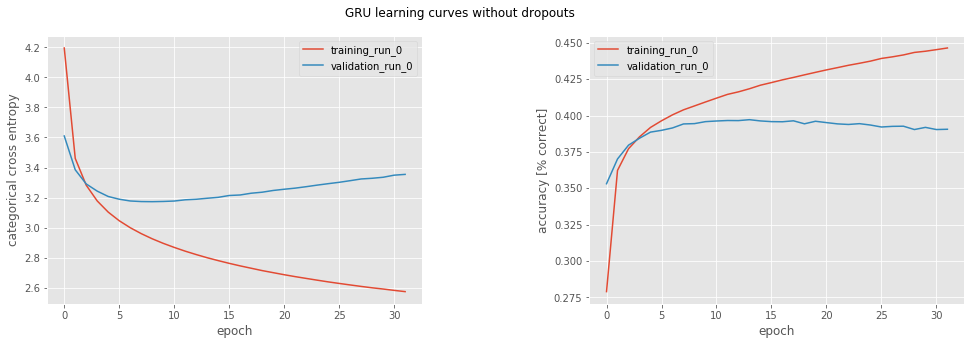

In [124]:
fig_GRU_nodrop = plot_history([logs["GRU_nodropouts"]], "GRU learning curves without dropouts")

<b>code Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt] </b>

In [57]:
# Simple rnn model
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          hidden_size,
                          1,
                          I, E, H, R, Y,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          model_type='RNN')

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 24, 64)            12352     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618555    
Total params: 1,252,987
Trainable params: 1,252,987
Non-trainable params: 0
_________________________________________________

In [28]:
def load_model_logs(model_path):
    #load RNN Model
    with open(model_path, "rb") as file:
        RNNmodel_log = pickle.load(file)
    return RNNmodel_log

In [116]:
def load_model_from_path(model_path):
    return load_model(model_path)

In [41]:
#GRU model
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          hidden_size,
                          1,
                          I, E, H, R, Y,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          model_type='GRU')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
gru_1 (GRU)                  (None, 24, 64)            37056     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618555    
Total params: 1,277,691
Trainable params: 1,277,691
Non-trainable params: 0
_________________________________________________

In [166]:
#LSTM model
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          hidden_size,
                          1,
                          I, E, H, R, Y,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          model_type='LSTM')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 64)            49408     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618555    
Total params: 1,290,043
Trainable params: 1,290,043
Non-trainable params: 0
_________________________________________________

<b>Figure Show the learning curves (training and validation loss) for the different recurrent units. [1 pt] </b>

<b>Figure Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt] </b>

In [48]:
# read saved logs
RRN_logs  = [load_model_logs("RNNmodel_128_64_1_log.pkl")]
GRU_logs  = [load_model_logs("GRUmodel_128_64_1_log.pkl")]
LSTM_logs = [load_model_logs("LSTMmodel_128_64_1_log.pkl")]

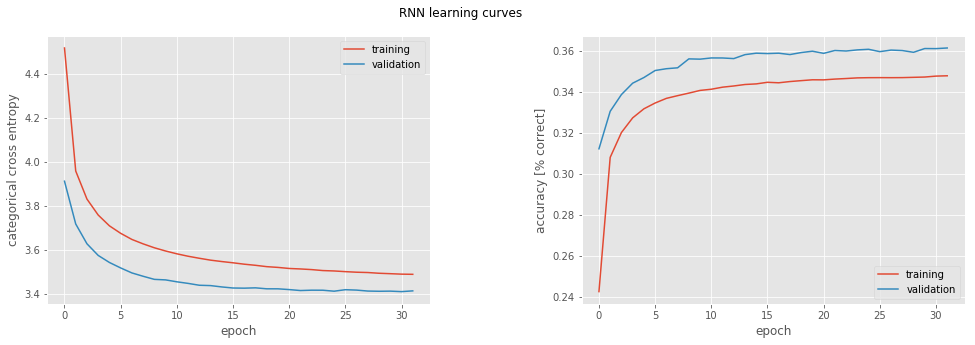

In [49]:
fig_RNN = plot_history(RRN_logs, "RNN learning curves")

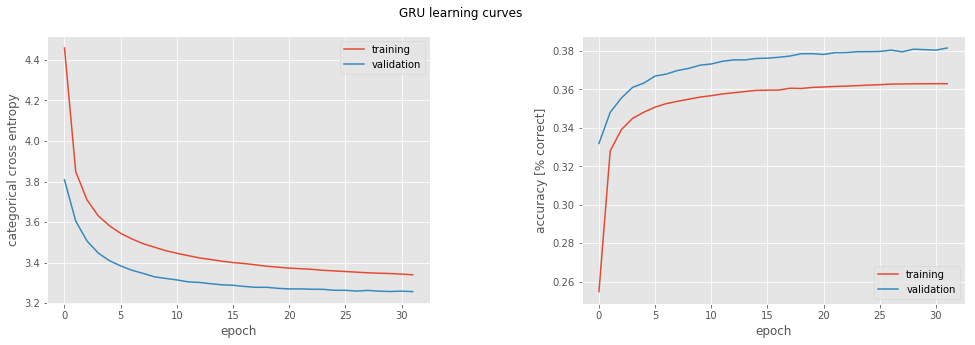

In [50]:
fig_GRU = plot_history(GRU_logs, "GRU learning curves")

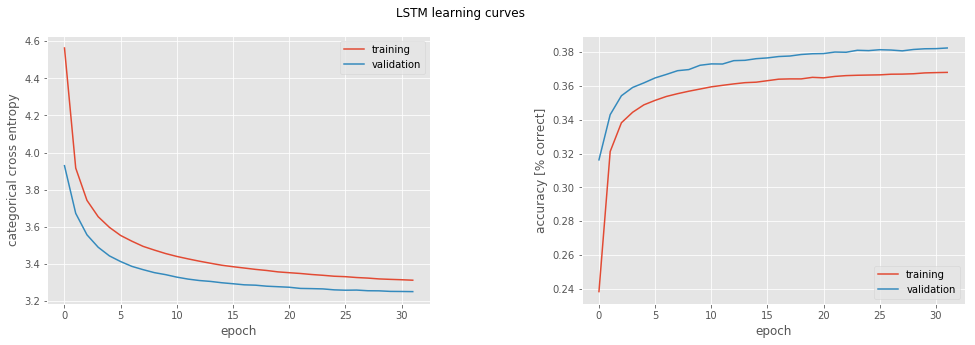

In [51]:
fig_LSTM = plot_history(LSTM_logs, "LSTM learning curves")

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer** We trained each model 2 times (could not do more because of computational/time limitations) for more accurate evaluation. We observe that training/validation loss and accuracy curve for all the above architectures are similar when using **dropouts**. However, GRU model with one hidden layer with 256 GRU seems to outperform other models slightly and achieves validation accuracy of around 39% with the given early stopping parameters. We also observe that validation loss is lower than training loss and thus models are underfitted (need more training epochs).

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer** EarlyStopping allows us to terminate training when validation loss does not improve over time. One of the advantages of using earlystopping is to prevent overfitting the model. However, there might be a case when the loss does not improve for few iteration (**vanishing gradients**) and starts improving again. In this case, there is a chance of underfitting the model if the patience value is too low.

**Question** What is your best model? Why? [1 pt]

**Answer** We chose to stick to GRU with single layer and 256 units as our best model as its learning curve shows both better validation and training accuracy/loss. However, to make any such claim, we should train our models for more epochs (since all models are underfitting: val loss smaller than training loss) and many times to get a better estimate of loss/accuracy curve. Due to time constraints, we trained a given model only twice.

In [42]:
I_GRU = {}
E_GRU = {}
H_GRU = {}
R_GRU = {}
Y_GRU = {}
# Get weigths of the embedding layer of pretrained model
embeddings_pre_trained = models['GRU'].layers[1].get_weights()

In [210]:
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          64,
                          1,
                          I_GRU, E_GRU, H_GRU , R_GRU, Y_GRU,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          early_stopping=True,
                          embedding_weights=embeddings_pre_trained,
                          model_type='GRU',
                          model_name='64',
                          run='2')

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
gru_5 (GRU)                  (None, 24, 64)            37056     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618555    
Total params: 1,277,691
Trainable params: 1,277,691
Non-trainable params: 0
_________________________________________________

In [76]:
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          128,
                          1,
                          I_GRU, E_GRU, H_GRU , R_GRU, Y_GRU,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          early_stopping=True,
                          embedding_weights=embeddings_pre_trained,
                          model_type='GRU',
                          model_name='128')

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
gru_12 (GRU)                 (None, 24, 128)           98688     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           16512     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618555    
Total params: 1,347,515
Trainable params: 1,347,515
Non-trainable params: 0
________________________________________________

In [43]:
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          256,
                          1,
                          I_GRU, E_GRU, H_GRU , R_GRU, Y_GRU,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          early_stopping=True,
                          embedding_weights=embeddings_pre_trained,
                          model_type='GRU',
                          model_name='256')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
gru_2 (GRU)                  (None, 24, 256)           295680    
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           32896     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618555    
Total params: 1,560,891
Trainable params: 1,560,891
Non-trainable params: 0
_________________________________________________

In [78]:
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          64,
                          2,
                          I_GRU, E_GRU, H_GRU , R_GRU, Y_GRU,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          early_stopping=True,
                          embedding_weights=embeddings_pre_trained,
                          model_type='GRU',
                          model_name='64_2')

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
gru_13 (GRU)                 (None, 24, 64)            37056     
_________________________________________________________________
gru_14 (GRU)                 (None, 24, 64)            24768     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618

In [206]:
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          128,
                          1,
                          I_GRU, E_GRU, H_GRU , R_GRU, Y_GRU,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          early_stopping=True,
                          embedding_weights=embeddings_pre_trained,
                          model_type='GRU',
                          model_name='128',
                          run='2')

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
gru_1 (GRU)                  (None, 24, 128)           98688     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           16512     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618555    
Total params: 1,347,515
Trainable params: 1,347,515
Non-trainable params: 0
_________________________________________________

In [207]:
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          256,
                          1,
                          I_GRU, E_GRU, H_GRU , R_GRU, Y_GRU,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          early_stopping=True,
                          embedding_weights=embeddings_pre_trained,
                          model_type='GRU',
                          model_name='256',
                          run='2')

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
gru_2 (GRU)                  (None, 24, 256)           295680    
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           32896     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          618555    
Total params: 1,560,891
Trainable params: 1,560,891
Non-trainable params: 0
_________________________________________________

In [209]:
append_run_language_model(nb_tokens,
                          max_tokens,
                          embedding_size,
                          64,
                          2,
                          I_GRU, E_GRU, H_GRU , R_GRU, Y_GRU,
                          models,
                          logs,
                          X, T,
                          dropout=0.5,
                          recurrent_dropout=0.5,
                          early_stopping=True,
                          embedding_weights=embeddings_pre_trained,
                          model_type='GRU',
                          model_name='64_2',
                          run='2')

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           613760    
_________________________________________________________________
gru_3 (GRU)                  (None, 24, 64)            37056     
_________________________________________________________________
gru_4 (GRU)                  (None, 24, 64)            24768     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 24, 128)           0         
_________________________________________________________________
output (TimeDistributed)     (None, 24, 4795)          6185

<b>Figure Show the learning curves (training and validation loss) for the four models. [1 pt] </b>

<b>Figure Show the learning curves (training and validation accuracy) for the four models. [1 pt]</b>

In [29]:
GRU_64_1_logs    = [load_model_logs("GRUmodel_128_64_1_log.pkl"),
                    load_model_logs("GRUmodel_128_64_1_log2.pkl")]

GRU_128_1_logs   = [load_model_logs("GRUmodel_128_128_1_log.pkl"),
                    load_model_logs("GRUmodel_128_128_1_log2.pkl")]

GRU_256_1_logs   = [load_model_logs("GRUmodel_128_256_1_log.pkl"),
                    load_model_logs("GRUmodel_128_256_1_log2.pkl")]

GRU_64_2_logs    = [load_model_logs("GRUmodel_128_64_2_log.pkl"),
                    load_model_logs("GRUmodel_128_64_2_log2.pkl")]

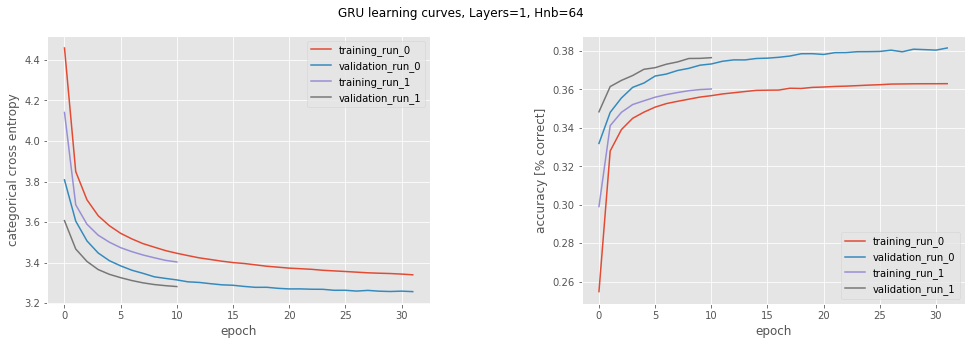

In [30]:
fig_GRU_64_1_logs = plot_history(GRU_64_1_logs, "GRU learning curves, Layers=1, Hnb=64")

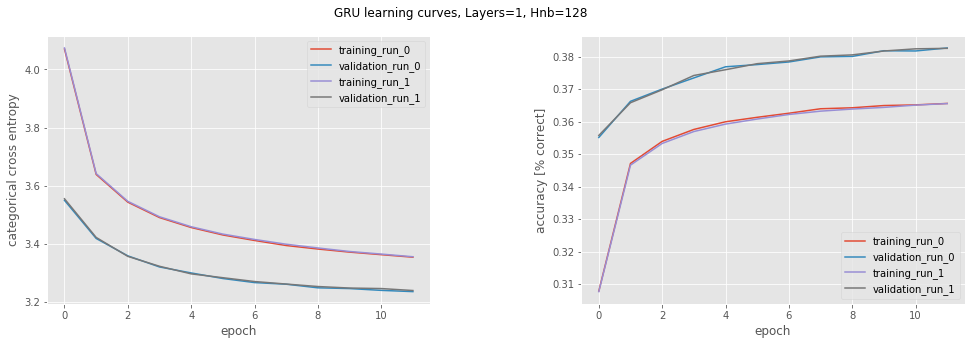

In [31]:
fig_GRU_128_1_logs = plot_history(GRU_128_1_logs, "GRU learning curves, Layers=1, Hnb=128")

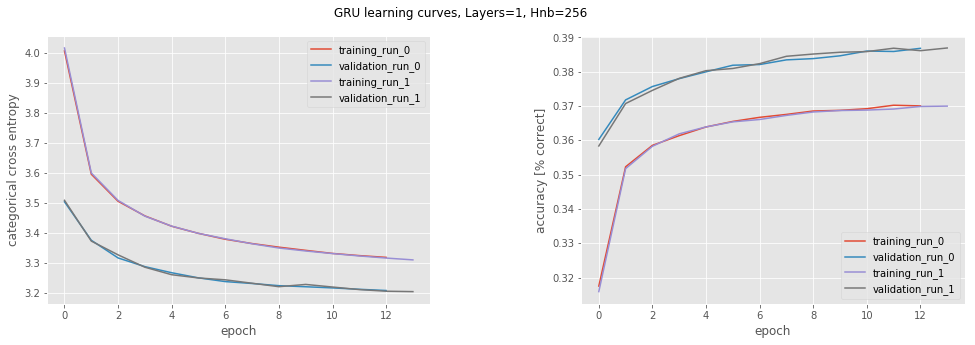

In [32]:
fig_GRU_256_1_logs = plot_history(GRU_256_1_logs, "GRU learning curves, Layers=1, Hnb=256")

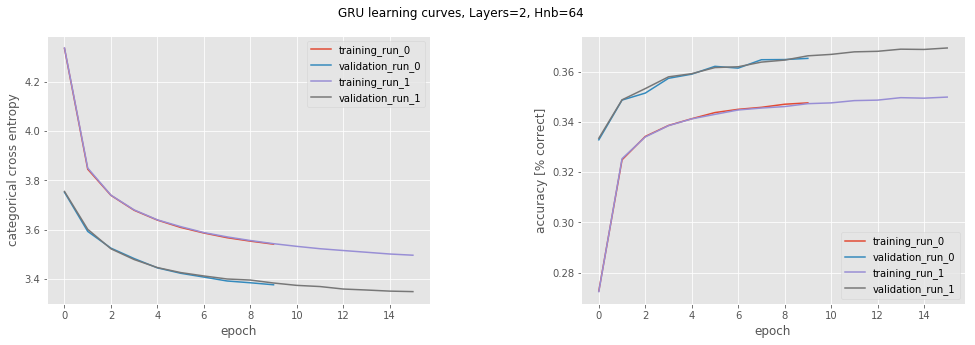

In [34]:
fig_GRU_64_2_logs = plot_history(GRU_64_2_logs, "GRU learning curves, Layers=2, Hnb=64")

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer** Temperature modifies distribution of probabilities for the next word occurance. Temperature close to zero means that word with the highest probability is predicted (Low temperatures cause a greater difference in selection probabilities for words with different predicted probabilities). Towards one we go close to selecting next word according to the softmax distribution. The higher the temperature, the uniformer the probabilities become (very close to each other). Therefore, temperature higher than 1.5 is as good as selecting a word randomly to be the next one.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer** 0 corresponds to selecting always the word with highest probability. Meaning, that prediction becomes deterministic and outputs the same thing for the same input.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer** Sampling temperature of one corresponds to drawing samples from the same distribution as the output probabilities (softmax).

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer** Very high sampling temperature corresponding to drawing samples from approximately uniform distribution (randomly).

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer** Sentence is generated step by step. At every step, we feed the sequence of words (**begining from 'START'**) already generated as input to the model to get the output probabilities over the volcabulary for the next word. We then randomly sample next word from this output distribution using temperature. If the output probability of a word is very high compared to the others, it is likely that this word gets selected. Therefore, we observe darker diagonal on the plot.

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer** Yes! we observe. Many of them represent the same part of speech. For example in case of the sentence "i am doing good . i love to drink ice cream " on position 6 (if positions start from 0, so 6 corresponds to "love") both "am" and "love" have non-zero probabilities since both of them are verbs and likely to appear after a subject "I".

Another example: i am a student . i am a teacher , i am a nurse . 
for student, teacher and nurse positions all three of them have non zero probabilities.

<b> Code To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts] </b>

In [65]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    
    # smoothing, adding small value for zero probabilities
    preds = np.log(preds + 1e-8) / temperature
    
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [66]:
def generate_sentence(model, dict_mapping, max_tokens, temperature=1., sentence=[]):
    """
    Generates new sentences from model
    
    :param model:         model for predictions
    :pemperature:         temperature to be used for sampling
    :sentence:            initial sentence given, created in method if None.
                          don't add START or END symbol to initial sentence. sentence should be a list of tokens (str or mapped)
    :dict_mapping:        list of vocabulary words where index of word gives its integer representation for embedding layer.
    """
    
    # store actual predicted words
    word_sentence = sentence.copy()
    word_mapping =  []
    
    # store prediction at each sentence position
    all_preds = []
    
    # start predicting from this index
    prediction_start = len(sentence)
    
    
    # check type of sentence is empty list
    if sentence and type(sentence[0] is str):
        sentence = [dict_mapping.index(word) for word in sentence]
    
    sentence = [dict_mapping.index('START')] + sentence
    sentence = pad_sequences([sentence], maxlen=max_tokens, padding='post', truncating='post')
    
    for i in range(prediction_start, max_tokens-1):
        
        # get predictions for the current sentence
        preds = model.predict(sentence)
        
        # save predictions for words for i+1 th position
        all_preds.append(preds[0][i])
        
        # sample the word prediciton for position i+1
        next_word = sample(preds[0][i], temperature)
        
        # insert predicted word (integer mapping) into sentence
        sentence[0, i+1] = next_word
        
        # save an actual predicted word
        word_sentence.append(dict_mapping[next_word])
        
        # save the predicted word (its token)
        word_mapping.append(next_word)
        
        # if the sentence end was predicted, end the process
        if(next_word == dict_mapping.index('END')):
            break
               
    # from all predictions select predictions only for words in the sentence
    sentence_word_preds = np.array(all_preds)[:, word_mapping]
    
    return " ".join(word_sentence), sentence_word_preds

In [87]:
sen, preds = generate_sentence(models['GRU256'], max_tokens=max_tokens-1, dict_mapping=dict_mapping)
if sen[-3:] == 'END':
    print(sen[:-3])
else:
    print(sen)

i am a dealer . do you have any hobbies ? 


<b> Code Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt] </b>

In [96]:
def generate_sentences(model, max_tokens, temperatures, dict_mapping):
    """
    Generate 10 senteces according to the model for each temperature in temperatures
    """

    temp_sentences = dict()
    temp_preds = dict()
    
    for temp in temperatures:
        print("Temperature: %.2f"%temp)
        for i in range(10):
            # generate a sentece according to the model and temperature
            sentence, preds = generate_sentence(model, max_tokens=max_tokens-1, temperature=temp, dict_mapping=dict_mapping)
            print_sent = sentence
            
            if sentence[-3:] == 'END':
                print_sent = sentence[:-3]
                
            print("%d) %s"%(i+1, print_sent))
            
            if temp in temp_sentences:
                temp_sentences[temp].append(sentence)
                temp_preds[temp].append(preds)
            else:
                temp_sentences[temp] = [sentence]
                temp_preds[temp] = [preds]
    
    return temp_sentences, temp_preds

In [97]:
temperatures = np.arange(0, 2.1, 0.25)    
temp_sentences, temp_preds = generate_sentences(models['GRU256'], max_tokens, temperatures, dict_mapping=dict_mapping)

Temperature: 0.00
1) i am a teacher . i am a teacher . 
2) i am a teacher . i am a teacher . 
3) i am a teacher . i am a teacher . 
4) i am a teacher . i am a teacher . 
5) i am a teacher . i am a teacher . 
6) i am a teacher . i am a teacher . 
7) i am a teacher . i am a teacher . 
8) i am a teacher . i am a teacher . 
9) i am a teacher . i am a teacher . 
10) i am a teacher . i am a teacher . 
Temperature: 0.25
1) i am a student . i am a teacher , i am a nurse . 
2) i am a teacher , but i am a teacher . 
3) i am a teacher . i am not a teacher . 
4) i am a teacher . i am a teacher . 
5) i am a nurse . i am a teacher . 
6) i am good . just got back from a school . 
7) i am good . i am a teacher . 
8) i am a teacher . i am a teacher . 
9) i am good . i am a waitress , i am a nurse . 
10) i am a waitress at a local hospital . i am a nurse . 
Temperature: 0.50
1) i am doing good . i love to drink ice cream 
2) i do not think i could drive , i am a fan of pizza . 
3) i am a fan of time . 


<b> 7 Figures For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts] </b>

Temperature: 0.00, Sentence: i am a teacher . i am a teacher . END


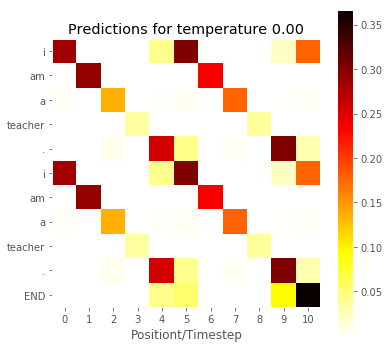

Temperature: 0.25, Sentence: i am a student . i am a teacher , i am a nurse . END


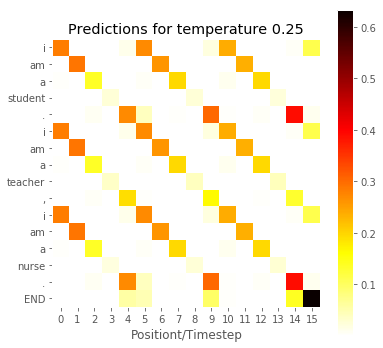

Temperature: 0.50, Sentence: i am doing good . i love to drink ice cream END


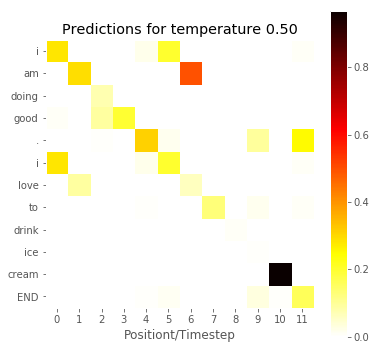

Temperature: 0.75, Sentence: oh that is unfortunate . i am trying to be in a rural hospital END


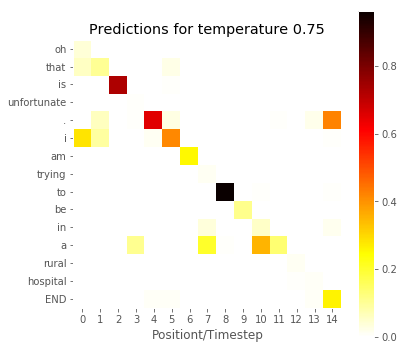

Temperature: 1.00, Sentence: i am great ! you ? is it just up ? END


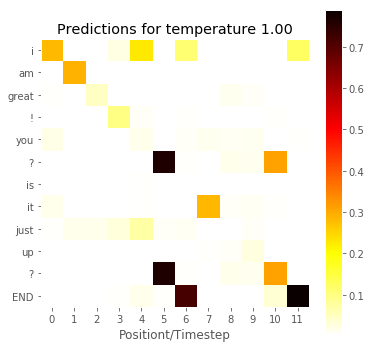

Temperature: 1.25, Sentence: no , a mother laugh i agree my music range helps them new programming END


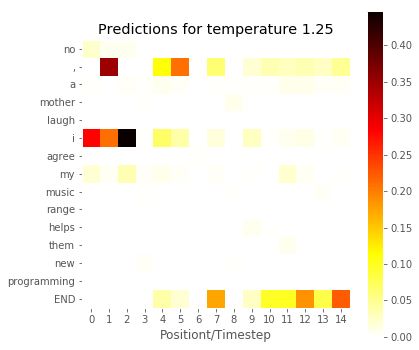

Temperature: 1.50, Sentence: do you enjoy games then END


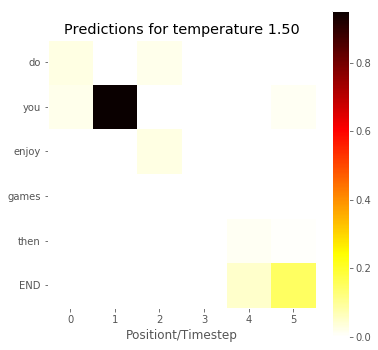

Temperature: 1.75, Sentence: expensive bands by cars people keep cows mexican list is cool do 386 the hot sports landing and sleeping called charities available ?


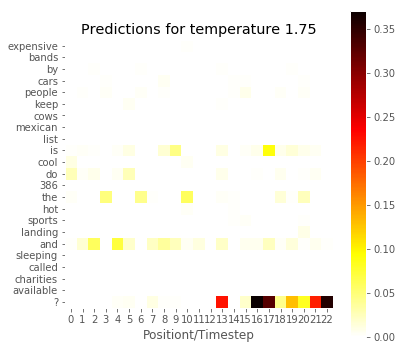

Temperature: 2.00, Sentence: wonderful ! small heard . do you sell my married also office walks last mile am okay hr . we woah option fair


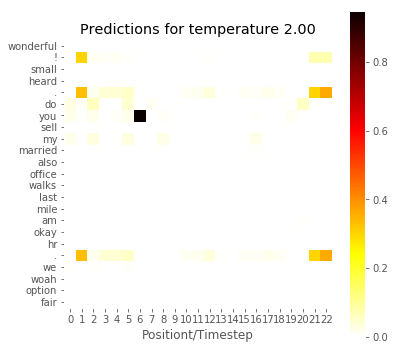

In [98]:
def plot_temp_predictions(temperatures, temp_preds, temp_sentences, sentence_nb = 1):
    
    for temp in temperatures:
        # select sentence for temperature (the first one by default)
        sentence = temp_sentences[temp][sentence_nb-1]
        # select predictions for the corresponding sentence and temp
        preds = temp_preds[temp][sentence_nb-1] #!!! prediction values of the same word might be more than once if the word
                                                # accures several times in a sentence. We did so to observe diagonal prediction!
        
        print("Temperature: %.2f, Sentence: %s"%(temp, sentence))

        
        plt.figure(figsize=(6,6))
        plt.title("Predictions for temperature %.2f"%temp)
           
        plt.imshow(np.transpose(preds), cmap='hot_r')  
        
        plt.xticks(np.arange(0, preds.shape[0]))
        plt.xlabel("Positiont/Timestep")
        
        plt.yticks(np.arange(0, preds.shape[0]), sentence.split())

        plt.colorbar()
        plt.show()
        
        #temp_preds[temp][sentence_nb-1]

plot_temp_predictions(temperatures, temp_preds, temp_sentences)


<b>Code Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]</b>

In [136]:
def generate_continuations(model, sentences, dict_mapping, nb_cont = 10, max_tokens=24):
    
    for sentence in sentences:
        print("Sentence: %s"%sentence)
        
        for i in range(nb_cont):
            pred_sentece, _ = generate_sentence(model,
                                                dict_mapping,
                                                max_tokens,
                                                temperature=0.7,
                                                sentence=sentence)
            print("Continuation %d) %s"%(i+1, pred_sentece))

In [139]:
my_sentence1 = ["our", "teacher", "is"]
my_sentence2 = ["i", "love"]
my_sentence3 = ["our","project"]
my_sentences = [my_sentence1, my_sentence2, my_sentence3]

generate_continuations(models['GRU256'], my_sentences, dict_mapping=dict_mapping)

Sentence: ['our', 'teacher', 'is']
Continuation 1) our teacher is a big nurse . END
Continuation 2) our teacher is the actual spirit so i am doing the meat . END
Continuation 3) our teacher is the same but i am moving next year ago END
Continuation 4) our teacher is a super good run i am addicted to phones to san francisco END
Continuation 5) our teacher is a student . END
Continuation 6) our teacher is a bit of such a vegetarian . i will have a lot of time to get a great idea END
Continuation 7) our teacher is a nurse . END
Continuation 8) our teacher is in my dad , but i am a girl END
Continuation 9) our teacher is not a little , i am a vet END
Continuation 10) our teacher is my mom 3 kids . END
Sentence: ['i', 'love']
Continuation 1) i love to eat healthy . i have five sisters END
Continuation 2) i love to go to the beach . i am a vegetarian . END
Continuation 3) i love chocolate ! i love jeopardy . END
Continuation 4) i love to listen to and country music . END
Continuation 5) i lo

###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer** We observe many clusters of words in the tsne plot which are syntactically or sementically related. For example: '**lol**' and '**haha**' have almost the same vector embeddings. Furthermore, **adjectives** such as '**awesome**', '**cool**', '**interesting**', '**good**', '**bad**' , are clustered together. Additionally there are clusters of **propositions** like '**in**', '**on**', '**from**', '**at**', '**by**', and clusters of **helping verbs** like '**being**', '**is**', '**are**', '**was**', '**do**', '**does**'.

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer** We would like our language model to learn similar vector representation for similar words in order to generalize well and generate sentences similar to the training distribution. As we can see in the above tsne plot, our model learns similar embeddings for different parts of speech words which is useful in uderstanding the main idea and syntax of a sentence. In order for it to generate syntactically correct sentences it needs to understand that nouns adjectives etc. are smilar. In order to understand meaning and convay meaning it needs to realize semantic meaning of words and cluster them together.

In [44]:
Input_embedding = Input(shape=(1,), name="input")
embedding_layer = Embedding(nb_tokens,
                            embedding_size,
                            mask_zero=True,
                            weights=models['GRU256'].layers[1].get_weights(),
                            name="embedding",
                            input_length=None,
                            trainable=False)(Input_embedding)

word_embedding_model = Model(inputs = [Input_embedding], outputs = [embedding_layer])

In [45]:
words_int = np.arange(1, len(dict_mapping))
all_embeddings = word_embedding_model.predict(words_int)

In [46]:
all_embeddings = all_embeddings.reshape((all_embeddings.shape[0], all_embeddings.shape[2]))

In [47]:
from sklearn.manifold import TSNE
all_embeddings_TSNE = TSNE(n_components=2).fit_transform(all_embeddings)

In [48]:
most_frequent_words = [word[0] for word in sorted_word_dictionary[:200]]

In [49]:
most_frequent_words_index = [dict_mapping.index(word)-1 for word in most_frequent_words]
frequent_word_embeddings_TSNE = all_embeddings_TSNE[most_frequent_words_index]

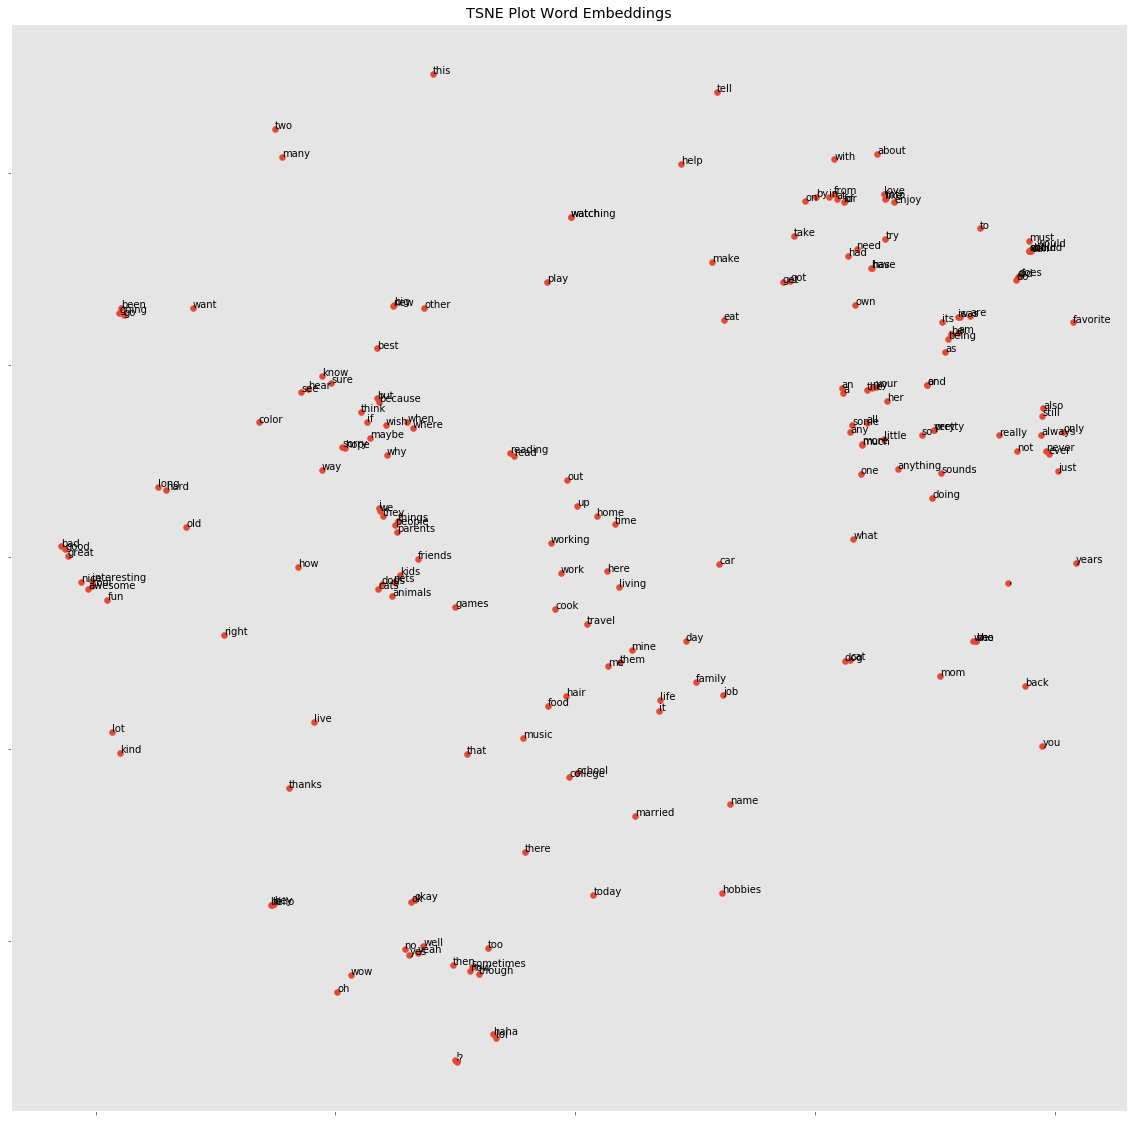

In [53]:
plt.figure(figsize=(20, 20))
plt.scatter(frequent_word_embeddings_TSNE[:, 0], frequent_word_embeddings_TSNE[:, 1])
plt.title("TSNE Plot Word Embeddings")
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])

for i, txt in enumerate(most_frequent_words):
    plt.annotate(txt, (frequent_word_embeddings_TSNE[i, 0], frequent_word_embeddings_TSNE[i, 1]))

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer** Mostly, generated and real answers are not similar but they convey the same/similar idea or the generated answer is meaningful even if it often does not correspond to the real answer/does not have the same idea (which is a desired behaviour). However, there are many generated answers that seems unrelated to the question asked. Our model does nice job in giving probable answer for temperature 0.5 and seem to perform badly for temperature 1.0.

**Good examples temperature 0.5**:

Question:      i like all music really , what do you do for a living  
Answer by bot: i am a student . i am a waitress .  
True answer:   i am still in school what about you

Question:      hi how are you doing ?
Answer by bot: i am doing well . just got back from work .
True answer:   i am good how about you ?

**Bad examples temperature 1.0**:

Question:      i sometimes like to hang around in bars . plus pancakes i guess .  
Answer by bot: basket ball is a lot of adventure and take care  
True answer:   i have a huge craving for pancakes right now  



**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer** Lower sampling temperatue seems to give better result for the chatbot. This is because the chatbot architecture. The encoder lstm absorbs the whole question and encodes the whole information as the final state vector which is passed on to the decoder as its initial state. The decoder then generates the sentence using this initial state. Since, at lower temperature we sample output with highest probability more often than at higher temperature, we get more deterministic answers at lower temperature.

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer** No. We would like our model to generate natural answers instead of memorizing them. Since we are picking the questions from the training data to test, if our model generates the same anserwer as the real one, then we are surely overfitting (memorizing the training data) and the model will not perform well on questions that it has not yet seen.

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]


<b>Code For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]</b>

In [122]:
def filter_converstaions(conversations, rare_words):
    """
    Selects question and answer pairs from conversations
    """
    q_a_dataset = [[], []]
    for conversation in conversations:
        
        # idetify number of question and answer in a conversation
        nb_q_a_paris = len(conversation)//2
        
        for i in range(nb_q_a_paris):
            
            q = conversation[2*i]
            a = conversation[2*i + 1]
            
            # drop them if one of them contains a word not in a dictionary
            if contains_rare_word(q.split(), rare_words) or contains_rare_word(a.split(), rare_words):
                continue
            
            q_a_dataset[0].append(q)
            q_a_dataset[1].append(a)
    
    return q_a_dataset[0], q_a_dataset[1]

In [123]:
q_orig , a_orig = filter_converstaions(conversations, rare_words)

<b>Code: You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]
</b>

In [124]:
def standardize_conversations(questions, answers, dict_mapping, max_len=27):
    """
    Standardize the list of questions and answers to be used for training. Performs padding and truncation and converts
    string words to corresponding integers in the list dict_mapping.
    
    Raises an error if number of questions is not equal to number of answers
    :param questions: List of all questions
    :param answers: List of corresponding answers
    :param dict_mapping: Mapping list used for converting words to integers
    :param max_len: Truncate sentences if they exceed max_len, otherwise padd them with zero.
    """
    assert(len(questions) == len(answers))
    
    # lists containg standardize questions and answers
    std_questions = []
    std_answers   = []
    
    # We don't want start and end words in questions
    for q, a in zip(questions, answers):
        question = []
        answer   = []
        
        for word in q.split():
            question.append(dict_mapping.index(word))
        
        answer.append(dict_mapping.index('START'))
        for word in a.split():
            answer.append(dict_mapping.index(word))
        answer.append(dict_mapping.index('END'))
        
        std_questions.append(question)
        std_answers.append(answer)
    
    std_questions = pad_sequences(std_questions, maxlen=max_len, padding='post', truncating='post')
    std_answers   = pad_sequences(std_answers, maxlen=max_len, padding='post', truncating='post')
    
    return std_questions, std_answers

In [125]:
q, a = standardize_conversations(q_orig, a_orig, dict_mapping, max_len=25)

<b> We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated.

Code: Train your chatbot model on your dataset. [1 pt] </b>

In [161]:
context = Input(shape=(max_tokens,), name="input_context")
shared_embedding = Embedding(nb_tokens,
                            embedding_size,
                            mask_zero=True,
                            weights=embeddings_pre_trained,
                            name="embedding",
                            input_length=None,
                            trainable=True)

context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(256, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=0.5,
            recurrent_dropout=0.5,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(max_tokens-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder = LSTM(256, 
            return_sequences=True,
            stateful=False,
            dropout=0.5,
            recurrent_dropout=0.5,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])

# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R_chatbot = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y_chatbot = TimeDistributed(Dense(nb_tokens, activation='softmax'), name='output')(R_chatbot)

Chatbot = Model(inputs = [context, answer], outputs = [Y_chatbot])
Chatbot.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, 24)           0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      (None, 25)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             613760      input_context[0][0]              
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 256), (None, 394240      embedding[0][0]            

In [163]:
X_chatbot = np.array(q)
A_chatbot = np.array(a)

T_chatbot = A.reshape((A.shape[0], A.shape[1], 1))
chatbox_log = Chatbot.fit({'input_context':X_chatbot, 'input_answer':A_chatbot[:, :-1]}, {'output': T_chatbot[:, 1:, :]}, 
                          epochs=15,
                          validation_split=validation_split,
                          batch_size=batch_size,
                          callbacks=[EarlyStopping()]).history

Train on 33899 samples, validate on 8475 samples
Epoch 1/15
33899/33899 [==============================] - 69s 2ms/step - loss: 4.3081 - acc: 0.2827 - val_loss: 3.7613 - val_acc: 0.3415
Epoch 2/15
33899/33899 [==============================] - 66s 2ms/step - loss: 3.6221 - acc: 0.3478 - val_loss: 3.5277 - val_acc: 0.3593
Epoch 3/15
33899/33899 [==============================] - 66s 2ms/step - loss: 3.4327 - acc: 0.3611 - val_loss: 3.4239 - val_acc: 0.3670
Epoch 4/15
33899/33899 [==============================] - 66s 2ms/step - loss: 3.3195 - acc: 0.3692 - val_loss: 3.3654 - val_acc: 0.3729
Epoch 5/15
33899/33899 [==============================] - 66s 2ms/step - loss: 3.2390 - acc: 0.3749 - val_loss: 3.3282 - val_acc: 0.3771
Epoch 6/15
33899/33899 [==============================] - 66s 2ms/step - loss: 3.1734 - acc: 0.3795 - val_loss: 3.2983 - val_acc: 0.3805
Epoch 7/15
33899/33899 [==============================] - 67s 2ms/step - loss: 3.1187 - acc: 0.3831 - val_loss: 3.2829 - val_acc:

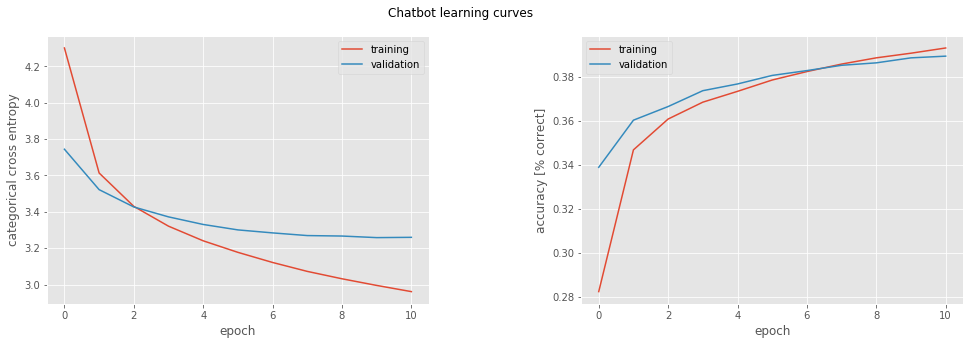

In [129]:
fig_chatbot = plot_history(chatbox_log, "Chatbot learning curves")

<b> Code Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] </b>

<b>Code After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]</b>

<b>Code Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 bonus pts]</b>

In [130]:
def chat_with_bot(model, query, dict_mapping, max_len=25, temperature=1.0):
    input_query = np.array([[dict_mapping.index(word) for word in query]])
    input_query = pad_sequences(input_query, maxlen=max_len, padding='post', truncating='post')
    
    response = [[dict_mapping.index('START')]]
    response = pad_sequences(response, maxlen=max_len-1, padding='post', truncating='post')
    
    response_words = []
    
    for i in range(max_len-2):
        preds = model.predict([input_query, response])
        next_word = sample(preds[0][i], temperature)
        
        if next_word == dict_mapping.index('END'):
            break
        response[0, i+1] = next_word
        response_words.append(dict_mapping[next_word])
    
    return " ".join(response_words)

In [214]:
# Random 10 contex-answer pairs
index = np.random.permutation(len(q_orig))[:10]
print("Temperature: 0.5")
for i in range(10):
    answer_bot = chat_with_bot(Chatbot, q_orig[index[i]].split(), dict_mapping, temperature=0.75)
    true_answer = a_orig[index[i]]
    print("\nQuestion:      {}\nAnswer by bot: {}\nTrue answer:   {}".format(q_orig[index[i]], answer_bot, true_answer))

Temperature: 0.5

Question:      my cats would be all over me if i tried that
Answer by bot: i love dancing too . do you have any hobbies ?
True answer:   try doing yoga all day

Question:      hi how are you today
Answer by bot: i am doing very well . just listening to my cats .
True answer:   i am fine i went to the doctors today

Question:      that is such a good one
Answer by bot: i would love that . i am glad to hear that .
True answer:   yes , i agree . i am hungry again . i need to make some food .

Question:      that is terrible awful . so sorry
Answer by bot: he is wonderful . what do you do for work ?
True answer:   i am a very passionate person about many things .

Question:      that makes me really happy . i need a break from school .
Answer by bot: that is great ! i am happy to keep up tough , but i do not wear my cane .
True answer:   i understand that school can be so hard

Question:      i don t do that much driving
Answer by bot: that is pretty cool . i love to read

In [131]:
# Random 10 contex-answer pairs
index = np.random.permutation(len(q_orig))[:10]
print("Temperature: 0.5")
for i in range(10):
    answer_bot = chat_with_bot(Chatbot, q_orig[index[i]].split(), dict_mapping, temperature=0.5)
    true_answer = a_orig[index[i]]
    print("\nQuestion:      {}\nAnswer by bot: {}\nTrue answer:   {}".format(q_orig[index[i]], answer_bot, true_answer))

Temperature: 0.5

Question:      yeah i really like dogs and cats they are my favorite
Answer by bot: i do not like to go out much . i am a mom and i have a dog
True answer:   i wish i had a pet but i work too much

Question:      well i am sure your dad is just looking out for you
Answer by bot: i would love to be a doctor , but i am sure .
True answer:   i really needed to pass the test

Question:      nah not really . i exercise indoors doing yoga so winter sports no big deal
Answer by bot: i love to read comic books .
True answer:   oh but the cold is so wonderful

Question:      well , if you can . . i suggest living next to a park or golf course its so nice !
Answer by bot: i am actually a stay in school .
True answer:   its going great just left work

Question:      hi lucy . its that time , winter . i just love the snow and the cold .
Answer by bot: i do not like to do that
True answer:   i am a summer kinda girl . surfer girl . what are your hobbies .

Question:      i like re

In [132]:
# Random 10 contex-answer pairs
index = np.random.permutation(len(q_orig))[:10]
print("Temperature: 1.0")

for i in range(10):
    answer_bot = chat_with_bot(Chatbot, q_orig[index[i]].split(), dict_mapping, temperature=1.0)
    true_answer = a_orig[index[i]]
    print("\nQuestion:      {}\nAnswer by bot: {}\nTrue answer:   {}".format(q_orig[index[i]], answer_bot, true_answer))

Temperature: 1.0

Question:      i love it because i can find it where i live easily .
Answer by bot: what do you do for a living ?
True answer:   that is great . i like to read draw

Question:      nice . my mom dances ballet .
Answer by bot: sorry to hear that . that sounds fun . i want to help now the others
True answer:   are you actually in high school

Question:      i sometimes like to hang around in bars . plus pancakes i guess .
Answer by bot: basket ball is a lot of adventure and take care
True answer:   i have a huge craving for pancakes right now

Question:      ah cool . i am a teacher actually . really .
Answer by bot: i like to be in sweden , which are you into ?
True answer:   i just turned 10 my mother is a teacher too

Question:      i like country music the most but jazz and hip hop are cool too
Answer by bot: ok its nice to give you with me a comic book .
True answer:   right on . what is your favorite food ? mine is pizza , my grandma makes the best

Question:     

In [133]:
def self_talking(model, init_thought, dict_mapping, temperature=0.75, conversation_len=100):
    answer = init_thought
    
    print("Person 1: {}".format(init_thought))
    for i in range(conversation_len):
        if i%2 == 0:
            person = "Person 2"
        else:
            person = "Person 1"
        answer = chat_with_bot(Chatbot, answer.split(), dict_mapping, temperature=temperature)
        print("{}: {}".format(person, answer))

In [134]:
# since every good conversation starts with a hi! :)
self_talking(Chatbot, "hi !", dict_mapping)

Person 1: hi !
Person 2: hello ! how are you ?
Person 1: i am good . i just got done with my dogs .
Person 2: that sounds like fun ! i am sorry for my birthday
Person 1: i have two kids and kids are organized to keep too busy .
Person 2: that is very cool . where do you live ?
Person 1: i was in chicago i am going to a movie theatre , but have been to a van
Person 2: are you a teacher ? i am a stay at home mom . i love it .
Person 1: i am not sure you can .
Person 2: i am a way so i have a bunch and cats , but i do not
Person 1: i am a country person , especially waking up !
Person 2: what do you do for a living ?
Person 1: i work at a band in the park
Person 2: i like to cook but i am a vegan too .
Person 1: what is it going to be ?
Person 2: i am from texas and thinking of the anniversary of my 4 dogs .
Person 1: wow , i am so old . i am a financial analyst , but they are so great .
Person 2: i am a beach student , i want to take a break from school .
Person 1: that is great . my dad